In [2]:
import sklearn
from tsai.basics import *
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
my_setup(sklearn)

os              : macOS-13.2.1-arm64-arm-64bit
python          : 3.10.10
tsai            : 0.3.6
fastai          : 2.7.12
fastcore        : 1.5.29
sklearn         : 1.2.2
torch           : 2.0.1
cpu cores       : 10
threads per cpu : 1
RAM             : 16.0 GB
GPU memory      : N/A


## Data Import

In [3]:
dsid = "ILI"
df_raw = get_long_term_forecasting_data(dsid)
df_raw

,date,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,ILITOTAL,NUM. OF PROVIDERS,OT
0,2002-01-01,1.222620,1.166680,582,805,2060,754,176569
1,2002-01-08,1.333440,1.216500,683,872,2267,785,186355
2,2002-01-15,1.319290,1.130570,642,878,2176,831,192469
3,2002-01-22,1.494840,1.252460,728,1045,2599,863,207512
4,2002-01-29,1.471950,1.302370,823,1189,2907,909,223208
...,...,...,...,...,...,...,...,...
961,2020-06-02,0.839059,0.846722,2756,3528,12913,3258,1525058
962,2020-06-09,0.895958,0.908885,3203,3778,13979,3254,1538038
963,2020-06-16,0.910926,0.941625,3478,3796,14389,3177,1528103
964,2020-06-23,0.946945,0.972185,3734,3818,14999,3066,1542813


## Preprocess Dataframe

In [4]:
datetime_col = "date"
freq = '7D'
columns = df_raw.columns[1:]
method = 'ffill'
value = 0

# pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage
    ('drop_duplicates', TSDropDuplicates(datetime_col=datetime_col)), # drop duplicate rows (if any)
    ('add_mts', TSAddMissingTimestamps(datetime_col=datetime_col, freq=freq)), # ass missing timestamps (if any)
    ('fill_missing', TSFillMissing(columns=columns, method=method, value=value)), # fill missing data (1st ffill. 2nd value=0)
    ], 
    verbose=True)
mkdir('data', exist_ok=True, parents=True)
save_object(preproc_pipe, 'data/preproc_pipe.pkl')
preproc_pipe = load_object('data/preproc_pipe.pkl')

df = preproc_pipe.fit_transform(df_raw)
df

data directory already exists.
Pipeline saved as data/preproc_pipe.pkl
Initial memory usage: 60.50 KB  
Final memory usage  : 30.31 KB   (-49.9%)
[Pipeline] .......... (step 1 of 4) Processing shrinker, total=   0.0s
[Pipeline] ... (step 2 of 4) Processing drop_duplicates, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing add_mts, total=   0.0s
[Pipeline] ...... (step 4 of 4) Processing fill_missing, total=   0.0s


,date,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,ILITOTAL,NUM. OF PROVIDERS,OT
0,2002-01-01,1.222620,1.166680,582,805,2060,754,176569
1,2002-01-08,1.333440,1.216500,683,872,2267,785,186355
2,2002-01-15,1.319290,1.130570,642,878,2176,831,192469
3,2002-01-22,1.494840,1.252460,728,1045,2599,863,207512
4,2002-01-29,1.471950,1.302370,823,1189,2907,909,223208
...,...,...,...,...,...,...,...,...
961,2020-06-02,0.839059,0.846722,2756,3528,12913,3258,1525058
962,2020-06-09,0.895958,0.908885,3203,3778,13979,3254,1538038
963,2020-06-16,0.910926,0.941625,3478,3796,14389,3177,1528103
964,2020-06-23,0.946945,0.972185,3734,3818,14999,3066,1542813


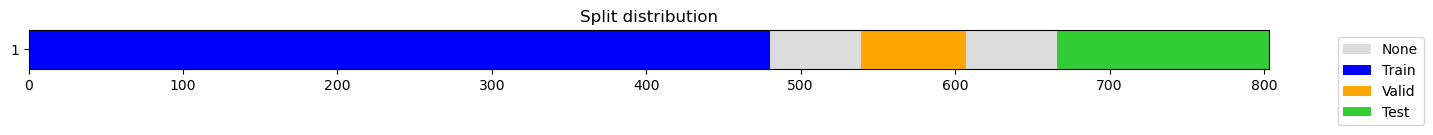

((#480) [0,1,2,3,4,5,6,7,8,9...],
 (#68) [539,540,541,542,543,544,545,546,547,548...],
 (#137) [666,667,668,669,670,671,672,673,674,675...])

In [5]:
fcst_history = 104 # # steps in the past
fcst_horizon = 60  # # steps in the future
valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

splits = get_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                valid_size=valid_size, test_size=test_size)
splits

## Scale Dataframe

In [6]:
columns = df.columns[1:]
train_split = splits[0]

# pipeline
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=columns)), # standardize data using train_split
    ], 
    verbose=True)
save_object(exp_pipe, 'data/exp_pipe.pkl')
exp_pipe = load_object('data/exp_pipe.pkl')

df_scaled = exp_pipe.fit_transform(df, scaler__idxs=train_split)
df_scaled

data directory already exists.
Pipeline saved as data/exp_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,date,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,ILITOTAL,NUM. OF PROVIDERS,OT
0,2002-01-01,-0.385132,-0.430517,-0.820532,-0.554250,-0.673272,-0.865932,-1.102387
1,2002-01-08,-0.298636,-0.388439,-0.771441,-0.539385,-0.649627,-0.801262,-1.056100
2,2002-01-15,-0.309680,-0.461015,-0.791369,-0.538053,-0.660022,-0.705300,-1.027182
3,2002-01-22,-0.172661,-0.358068,-0.749568,-0.501000,-0.611704,-0.638544,-0.956031
4,2002-01-29,-0.190526,-0.315914,-0.703392,-0.469050,-0.576523,-0.542582,-0.881791
...,...,...,...,...,...,...,...,...
961,2020-06-02,-0.684507,-0.700752,0.236159,0.049916,0.566424,4.357746,5.275777
962,2020-06-09,-0.640097,-0.648249,0.453427,0.105385,0.688189,4.349402,5.337171
963,2020-06-16,-0.628414,-0.620597,0.587093,0.109378,0.735021,4.188769,5.290179
964,2020-06-23,-0.600301,-0.594786,0.711524,0.114260,0.804699,3.957209,5.359756


## Sliding Window

In [7]:
x_vars = df.columns[1:]
y_vars = df.columns[1:]
X, y = prepare_forecasting_data(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
X.shape, y.shape

((803, 7, 104), (803, 7, 60))

In [8]:
# Just for MacUsers

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [9]:
arch_config = dict(
    n_layers=3,  # number of encoder layers
    n_heads=4,  # number of heads
    d_model=16,  # dimension of model
    d_ff=128,  # dimension of fully connected network
    attn_dropout=0.0, # dropout applied to the attention weights
    dropout=0.3,  # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len=24,  # length of the patch applied to the time series to create patches
    stride=2,  # stride used when creating patches
    padding_patch=True,  # padding_patch
)

In [10]:
learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=ShowGraph())

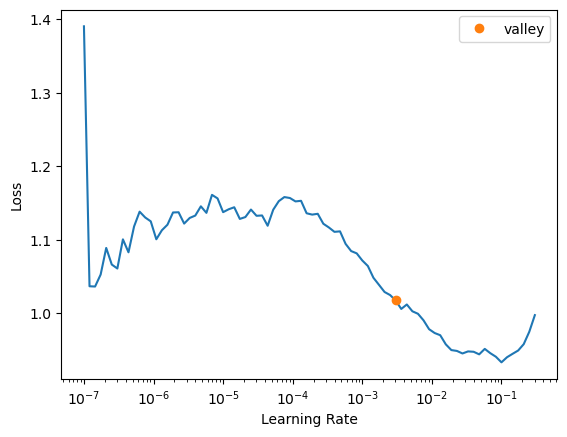

In [11]:
lr_max = learn.lr_find().valley

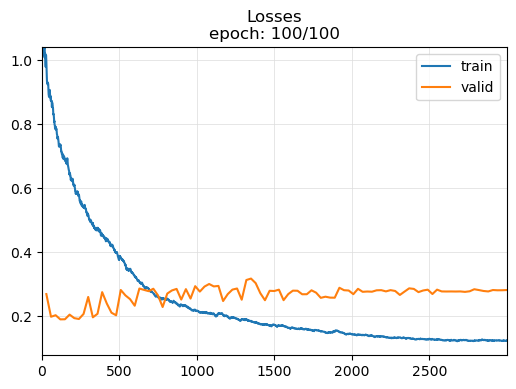

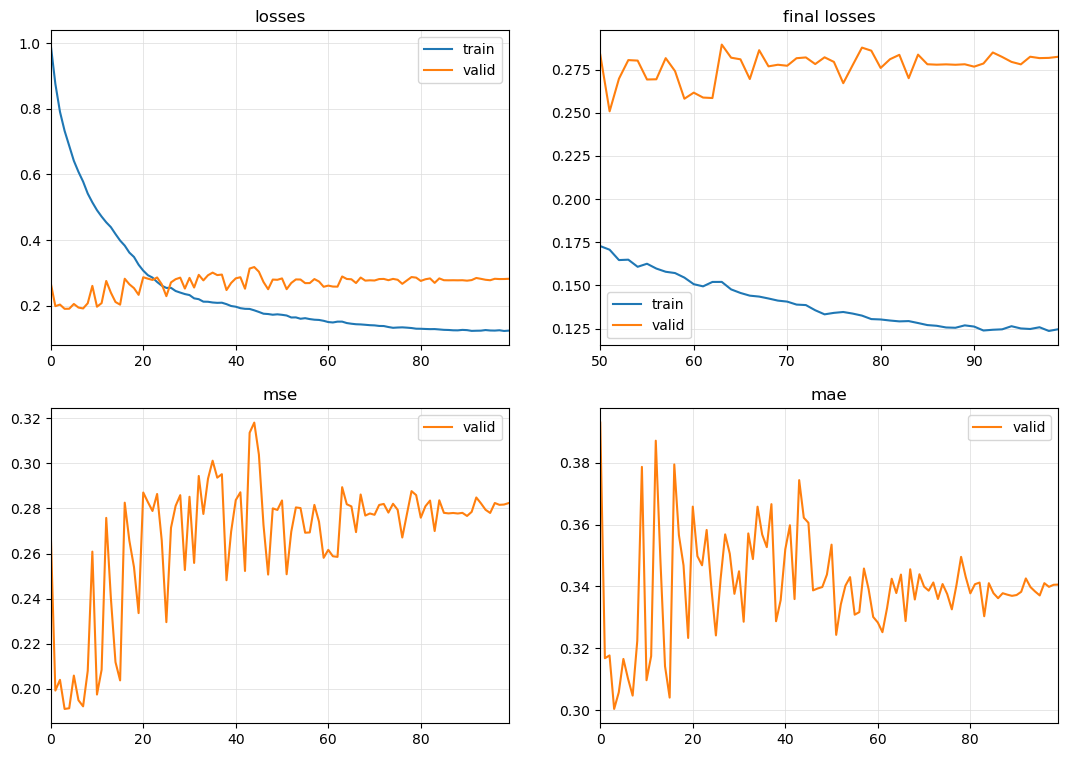

In [12]:
learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=[ShowGraph()])

n_epochs = 100
lr_max = 0.0025
learn.fit_one_cycle(n_epochs, lr_max=lr_max)
learn.export('patchTST.pt')

## Evaluate model

In [13]:
learn = load_learner('models/patchTST.pt')
scaled_preds, *_ = learn.get_X_preds(X[splits[1]])
scaled_preds = to_np(scaled_preds)
print(f"scaled_preds.shape: {scaled_preds.shape}")

scaled_y_true = y[splits[1]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df

scaled_preds.shape: (68, 7, 60)


,mse,mae
valid,0.2824,0.340595


## Test Inference

In [16]:
learn = load_learner('models/patchTST.pt')
y_test_preds, *_ = learn.get_X_preds(X[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df

y_test_preds.shape: (137, 7, 60)


,mse,mae
test,1.504633,0.798984


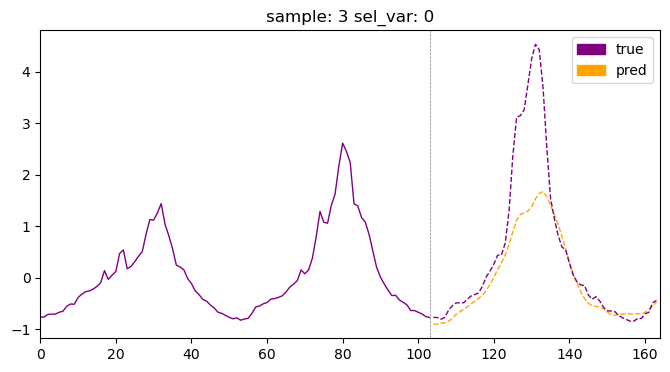

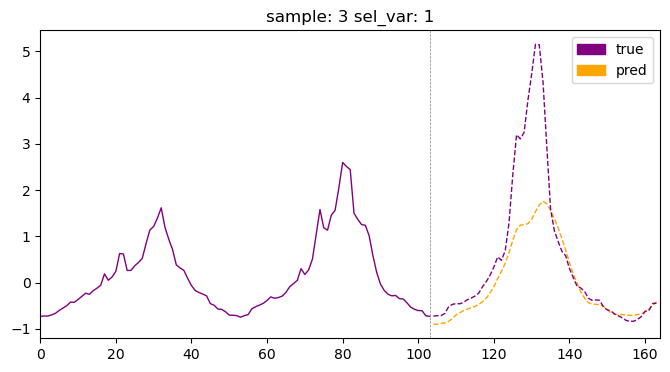

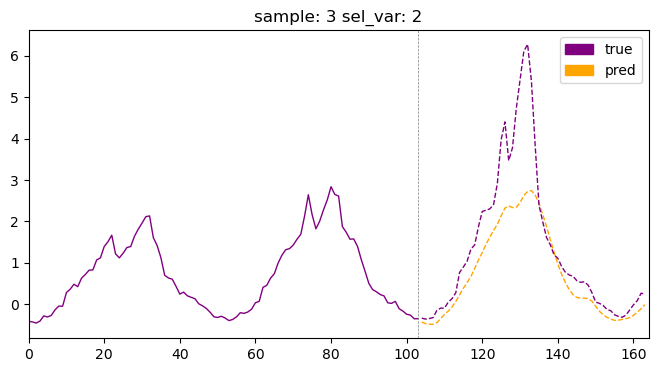

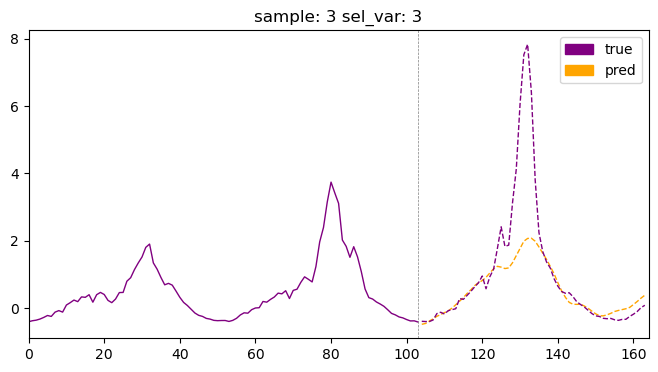

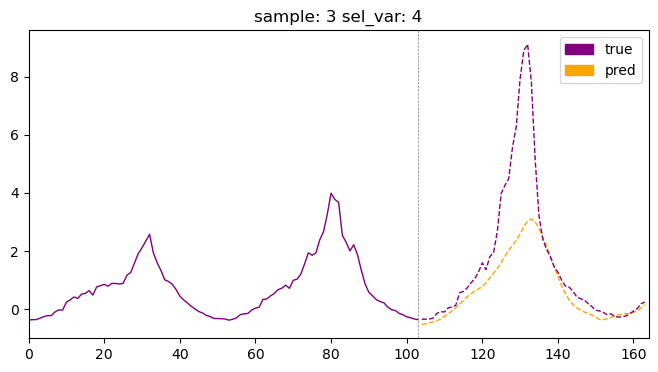

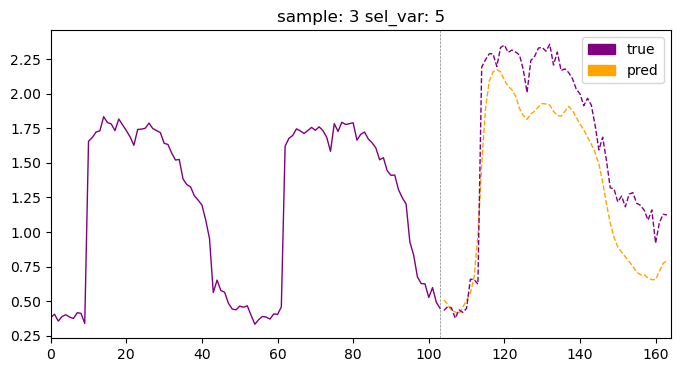

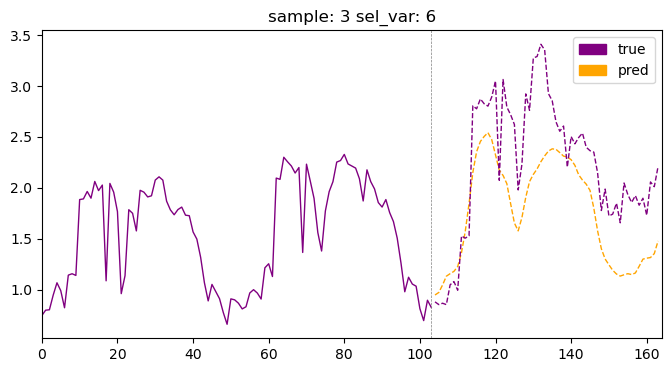

In [17]:
X_test = X[splits[2]]
y_test = y[splits[2]]
plot_forecast(X_test, y_test, y_test_preds, sel_vars=True)

In [18]:
fcst_date = "2020-06-30"
dates = pd.date_range(start=None, end=fcst_date, periods=fcst_history, freq=freq)
new_df = get_long_term_forecasting_data(dsid, return_df=True)
new_df = new_df[new_df[datetime_col].isin(dates)].reset_index(drop=True)
save_new_df = new_df


learn = load_learner('models/patchTST.pt')
new_df = learn.transform(new_df)

Initial memory usage: 6.62 KB   
Final memory usage  : 3.38 KB    (-49.1%)


In [19]:
x_feat = new_df.columns[1:]
new_X, _ = prepare_forecasting_data(new_df, fcst_history=fcst_history, fcst_horizon=0, x_vars=x_vars, y_vars=None)

In [20]:
new_scaled_preds, *_ = learn.get_X_preds(new_X)

new_scaled_preds = to_np(new_scaled_preds).swapaxes(1,2).reshape(-1, len(y_vars))
dates = pd.date_range(start=fcst_date, periods=fcst_horizon + 1, freq='7D')[1:]
preds_df = pd.DataFrame(dates, columns=[datetime_col])
preds_df.loc[:, y_vars] = new_scaled_preds
preds_df = learn.inverse_transform(preds_df)

In [21]:
df_total_pred= pd.concat([save_new_df, preds_df], ignore_index = True)
df_total_pred = df_total_pred.iloc[-200:]

In [22]:
columns_full=list(new_df.columns)
dict_name = {x: y for x, y in enumerate(columns_full)}
df_total_pred.rename(columns=dict_name, inplace=True)

2020-06-30 00:00:00


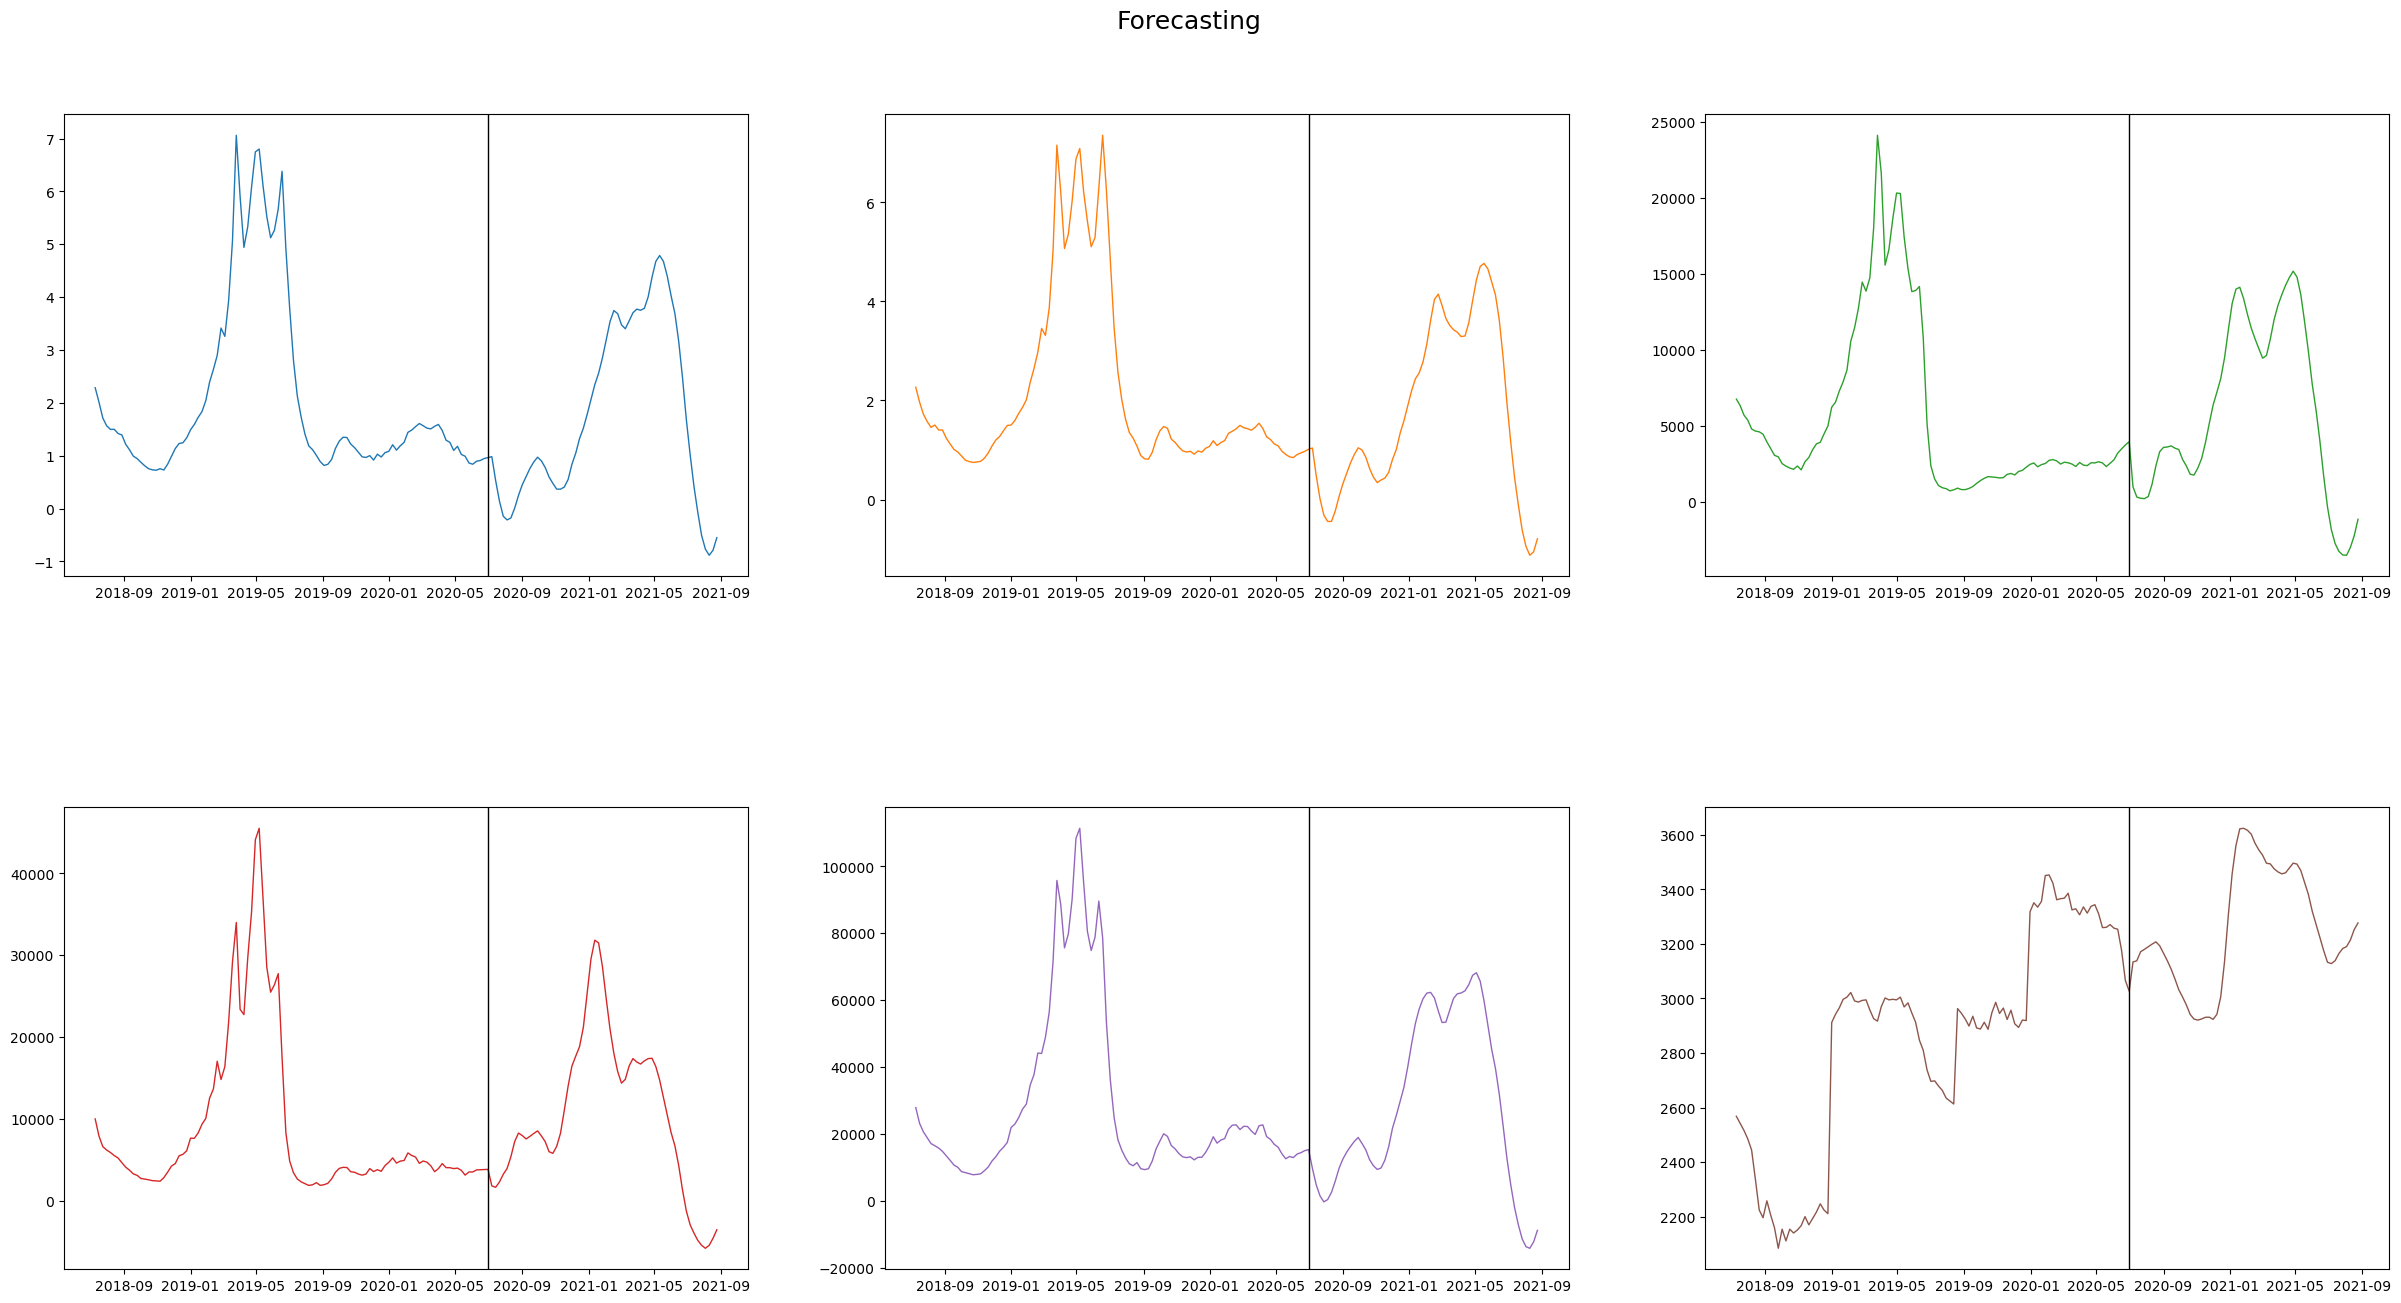

In [23]:

date_str = fcst_date
date_format = '%Y-%m-%d'
date_obj = datetime.strptime(date_str, date_format)
print(date_obj)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30, 15))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Forecasting", fontsize=18, y=0.95)
colors = ['C{}'.format(k) for k in range(16)]

for i, (column, ax) in enumerate(zip(columns_full[1:], axs.ravel())):
    # filter df for ticker and plot on specified axes
    ax.plot(df_total_pred['date'], df_total_pred[column], linestyle='-', color = colors[i],linewidth=1)
    ax.axvline(x=date_obj, linewidth=1, color='black')

plt.show()